# NorthWind Traders Data Analysis

NorthWind Traders is a fictitious international gourmet food distributor. This project aims to provide management with insights in the following areas.  
* Evaluating employee performance to boost productivity.
* Understanding product sales and category performance to optimize inventory and marketing strategies.
* Analyzing sales growth to identify trends, monitor company progress, and make more accurate forecasts.
* And evaluating customer purchase behavior to target high-value customers with promotional incentives.  

The dataset is available via the following [Link](https://github.com/pthom/northwind_psql/tree/master).
I followed the instruction from [Dataquest](https://www.dataquest.io/blog/install-postgresql-14-7-for-macos/?_gl=1*1vrbtn6*_gcl_au*NjQ1OTI0MzQxLjE3MTYyNzUyMDY) to install postgres using Homebrew.

The schema is shown as follows. ![image](https://github.com/moscmh/NorthWind/blob/main/ER.png?raw=true)

In [55]:
# Enable SQL extension and connect to database
%load_ext sql
%sql postgresql://postgres@localhost:5432/northwind

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [56]:
# Libraries
import pandas as pd # turning SQL outputs into Python dataframe structure.
import matplotlib.pyplot as plt # visualization
import matplotlib as mpl # plots options
mpl.style.use("ggplot") # plots style as ggplot

# Content
1. [Sales Performance Based on Employees Performance](#employee)
2. [Company's Overall Sales Performance](#company)
3. [High-Value Customers](#customer)
4. [Categories Performance](#category)
5. [Conclusion](#conclusion)

## Sales Performance Based on Employees Performance <a class="anchor" id="employee"></a>
### Total Sales per Employee

In [57]:
# SQL Query for getting employees information
query = """
SELECT
    E.employee_id, E.first_name || ' ' || E.last_name AS name, E.title,
    ROUND( SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS total_sales
FROM
    employees E
INNER JOIN orders O ON E.employee_id = O.employee_id
INNER JOIN order_details OD ON O.order_id = OD.order_id
GROUP BY E.employee_id
ORDER BY total_sales DESC
"""
# Run query ann store output as result variable
result = %sql $query 
employee_sales = pd.DataFrame(result) # Turn SQL output into dataframe structure for visualization
employee_sales

 * postgresql://postgres@localhost:5432/northwind
9 rows affected.


,employee_id,name,title,total_sales
0,4,Margaret Peacock,Sales Representative,232891
1,3,Janet Leverling,Sales Representative,202813
2,1,Nancy Davolio,Sales Representative,192108
3,2,Andrew Fuller,"Vice President, Sales",166538
4,8,Laura Callahan,Inside Sales Coordinator,126862
5,7,Robert King,Sales Representative,124568
6,9,Anne Dodsworth,Sales Representative,77308
7,6,Michael Suyama,Sales Representative,73913
8,5,Steven Buchanan,Sales Manager,68792


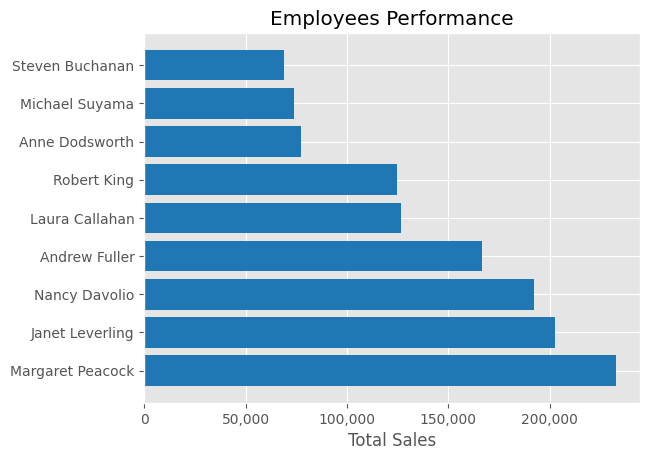

In [58]:
%matplotlib inline
plt.barh(employee_sales["name"], employee_sales["total_sales"], color='tab:blue')
plt.xlabel("Total Sales")
plt.gca().xaxis.set_major_formatter(plt.matplotlib.ticker.StrMethodFormatter('{x:,.0f}')) # Formatting x-axis tickers' format
plt.title("Employees Performance")
plt.show()

In [59]:
%%sql -- Adding Ranking
SELECT *,
    RANK() OVER(ORDER BY total_sales DESC 
                ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS rank
FROM (
    SELECT
        E.employee_id, E.first_name || ' ' || E.last_name AS name, E.title,
        ROUND( SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS total_sales
    FROM
        employees E
    INNER JOIN orders O ON E.employee_id = O.employee_id
    INNER JOIN order_details OD ON O.order_id = OD.order_id
    GROUP BY E.employee_id
    ORDER BY total_sales DESC
) AS sub

 * postgresql://postgres@localhost:5432/northwind
9 rows affected.


employee_id,name,title,total_sales,rank
4,Margaret Peacock,Sales Representative,232891,1
3,Janet Leverling,Sales Representative,202813,2
1,Nancy Davolio,Sales Representative,192108,3
2,Andrew Fuller,"Vice President, Sales",166538,4
8,Laura Callahan,Inside Sales Coordinator,126862,5
7,Robert King,Sales Representative,124568,6
9,Anne Dodsworth,Sales Representative,77308,7
6,Michael Suyama,Sales Representative,73913,8
5,Steven Buchanan,Sales Manager,68792,9


Sales Representative, Margaret Peacock, has achieved the greatest total sales in the company. Apart from all time record, I suggest looking at the performance in a shorter time frame such as total sales within the past year.

In [60]:
%%sql -- Adding Ranking
SELECT *,
    RANK() OVER(ORDER BY total_sales DESC 
                ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING) AS rank
FROM (
    SELECT
        E.employee_id, E.first_name || ' ' || E.last_name AS name, E.title,
        ROUND( SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS total_sales
    FROM
        employees E
    INNER JOIN orders O ON E.employee_id = O.employee_id
    INNER JOIN order_details OD ON O.order_id = OD.order_id
    WHERE O.order_date >= (SELECT order_date FROM orders ORDER BY 1 DESC LIMIT 1) - INTERVAL '1 year'
    GROUP BY E.employee_id
    ORDER BY total_sales DESC
) AS sub

 * postgresql://postgres@localhost:5432/northwind
9 rows affected.


employee_id,name,title,total_sales,rank
3,Janet Leverling,Sales Representative,145543,1
1,Nancy Davolio,Sales Representative,137690,2
4,Margaret Peacock,Sales Representative,127230,3
2,Andrew Fuller,"Vice President, Sales",124173,4
8,Laura Callahan,Inside Sales Coordinator,85137,5
7,Robert King,Sales Representative,81461,6
9,Anne Dodsworth,Sales Representative,64377,7
5,Steven Buchanan,Sales Manager,47888,8
6,Michael Suyama,Sales Representative,43778,9


If only considering the past year, Janet Leverling has the best performance in terms of total sales.

## Company's Overall Sales Performance <a class="anchor" id="company"></a>
### Visualization on Percentage Change by Month

In [61]:
%%sql -- total sales for each month

WITH truncated AS (
    SELECT order_id, DATE_TRUNC('month', order_date) AS date
    FROM orders
)

SELECT
    EXTRACT(YEAR FROM T.date) || '-' || EXTRACT(MONTH FROM T.date) AS month,
    ROUND(SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS monthly_sales,
    ROUND(SUM(SUM(OD.unit_price * OD.quantity * (1-OD.discount))) 
          OVER(ORDER BY T.date)::numeric, 0) AS RunningTotal
FROM truncated T
INNER JOIN order_details OD ON T.order_id = OD.order_id
GROUP BY T.date
ORDER BY T.date

 * postgresql://postgres@localhost:5432/northwind
23 rows affected.


month,monthly_sales,runningtotal
1996-7,27862,27862
1996-8,25485,53347
1996-9,26381,79729
1996-10,37516,117244
1996-11,45600,162844
1996-12,45240,208084
1997-1,61258,269342
1997-2,38484,307826
1997-3,38547,346373
1997-4,53033,399406


In [62]:
query = '''
WITH truncated AS (
    SELECT order_id, DATE_TRUNC('month', order_date) AS date
    FROM orders
)

SELECT
    EXTRACT(YEAR FROM T.date) || '-' || EXTRACT(MONTH FROM T.date) AS month,
    ROUND(SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS monthly_sales,
    ROUND(SUM(SUM(OD.unit_price * OD.quantity * (1-OD.discount))) 
          OVER(ORDER BY T.date)::numeric, 0) AS RunningTotal
FROM truncated T
INNER JOIN order_details OD ON T.order_id = OD.order_id
GROUP BY T.date
ORDER BY T.date
'''
result = %sql $query
monthly_performance = pd.DataFrame(result)

 * postgresql://postgres@localhost:5432/northwind
23 rows affected.


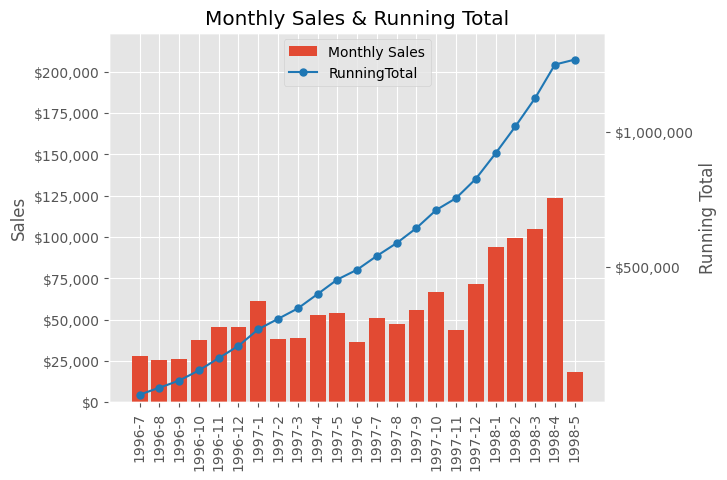

In [63]:
fig, ax = plt.subplots()
twin1 = ax.twinx()

ax.set_title("Monthly Sales & Running Total")

p1 = ax.bar('month', 'monthly_sales', data=monthly_performance, label='Monthly Sales')
ax.set(ylim=(0,monthly_performance['monthly_sales'].max()+100000), ylabel='Sales')
ax.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.set_xticks(monthly_performance['month'], monthly_performance['month'], rotation='vertical')

p2 = twin1.plot('month', 'runningtotal', marker='o', color='tab:blue', markersize=5, data=monthly_performance, label='RunningTotal')
twin1.set(ylim=(0,monthly_performance['runningtotal'].max()+100000), ylabel='Running Total')
twin1.ticklabel_format(style='plain', axis='y')
twin1.set_yticks([500000,1000000], [500000,1000000])
twin1.yaxis.set_major_formatter('${x:,.0f}')
twin1.grid(False)

ax.legend(handles=[p1,p2[0]], loc='upper center')
plt.show()

From 1996-07 to 1997-10, NorthWind's total sales was increasing gradually in a nearly uniform rate. Since 1997-12, performance in terms of sales had been improved as shown in the steeper line and higher bars. However, the performance in the last month in the record dropped significantly.

### Month-Over-Month Growth Rate

In [64]:
query = '''
WITH 
truncated AS (
    SELECT order_id, DATE_TRUNC('month', order_date) AS date
    FROM orders),

monthly AS (
    SELECT 
        T.date,
        EXTRACT(YEAR FROM T.date) || '-' || EXTRACT(MONTH FROM T.date) AS month,
        ROUND(SUM(SUM(OD.unit_price * OD.quantity * (1-OD.discount))) 
              OVER(PARTITION BY T.date)::numeric, 0) AS monthly_sales
    FROM order_details OD
    INNER JOIN truncated T ON OD.order_id = T.order_id
    GROUP BY T.date)

SELECT month, monthly_sales,
    ROUND( (monthly_sales-(LAG(monthly_sales, 1) OVER()))*100/
          (LAG(monthly_sales, 1) OVER())::numeric, 0 ) AS growth_rate
FROM monthly
'''
result = %sql $query
monthly_growth = pd.DataFrame(result)

 * postgresql://postgres@localhost:5432/northwind
23 rows affected.


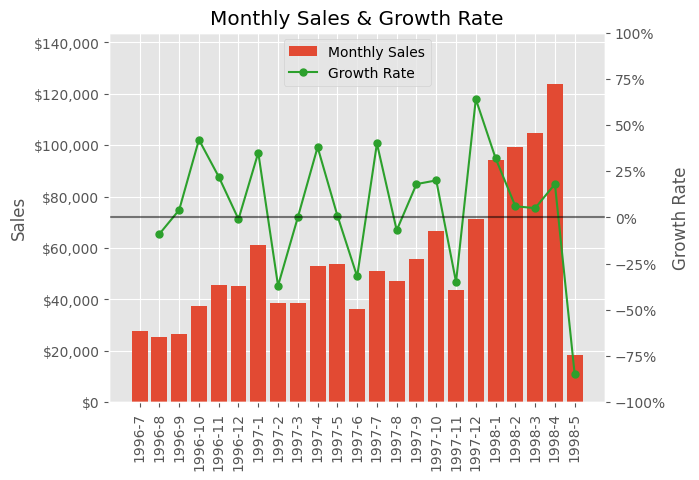

In [65]:
fig, ax = plt.subplots()
twin1 = ax.twinx()

ax.set_title("Monthly Sales & Growth Rate")

p1 = ax.bar('month', 'monthly_sales', data=monthly_growth, label='Monthly Sales')
ax.set(ylim=(0,monthly_growth['monthly_sales'].max()+20000), ylabel='Sales')
ax.ticklabel_format(style='plain', axis='y')
ax.yaxis.set_major_formatter('${x:,.0f}')
ax.set_xticks(monthly_growth['month'], monthly_growth['month'], rotation='vertical')

p2 = twin1.plot('month', 'growth_rate', marker='o', color='tab:green', markersize=5, data=monthly_growth, label='Growth Rate')
twin1.set(ylim=(-100,100), ylabel='Growth Rate')
twin1.ticklabel_format(style='plain', axis='y')
twin1.yaxis.set_major_formatter('{x:.0f}%')
twin1.grid(False)
twin1.axhline(0, color='black', alpha=.5)

ax.legend(handles=[p1,p2[0]], loc='upper center')
plt.show()

## High-Value Customers <a class="anchor" id="customer"></a>
In the following section, I try to identify the high-value customers by looking at the order details. Mean of all the orders is used to determine if an order is an above average or a below average order. 

In [66]:
%%sql -- mean of orders
SELECT AVG(order_price)
FROM (
    SELECT SUM(unit_price * quantity * (1-discount)) AS order_price
    FROM order_details 
    GROUP BY order_id
) AS order_prices


 * postgresql://postgres@localhost:5432/northwind
1 rows affected.


avg
1525.0518537992339


In [67]:
%%sql

WITH 
custs AS (
    SELECT O.customer_id, O.order_id, C.country,
        SUM( ROUND((OD.unit_price * OD.quantity * (1-OD.discount))::numeric,2) ) AS price
    FROM orders O
    INNER JOIN customers C ON O.customer_id=C.customer_id
    INNER JOIN order_details OD ON O.order_id=OD.order_id
    GROUP BY 2, 3),

h_b_value AS (    
    SELECT customer_id, order_id, price, country,
        CASE 
        WHEN price > AVG(price) OVER()
        THEN 'Above Average' ELSE 'Below Average'
        END AS value
    FROM custs),

high_count AS (
    SELECT customer_id, country, COUNT(*) AS highs
    FROM h_b_value 
    WHERE value LIKE 'Above%' 
    GROUP BY 1, 2)

SELECT DISTINCT C.customer_id, C.country,
    CASE
    WHEN HC.highs > 0 THEN HC.highs
    ELSE 0 END AS highs
FROM custs C
LEFT JOIN high_count HC ON C.customer_id=HC.customer_id
ORDER BY 3 DESC
LIMIT 5

 * postgresql://postgres@localhost:5432/northwind
5 rows affected.


customer_id,country,highs
SAVEA,USA,26
ERNSH,Austria,26
QUICK,Germany,22
HUNGO,Ireland,11
RATTC,USA,10


Top 5 customers are SAVEA, ERNSH, QUICK, HUNGO, and RATTC. They have made the greatest number of above average orders. Management may decide to target the top customers on the list with exclusive advertisement.

## Categories Performance <a class="anchor" id="category"></a>
Next, I focus on finding the categories which contributed to biggest sales for the company.

In [68]:
%%sql
WITH 
cat_sums AS (
    SELECT
        C.category_id, C.category_name,
        ROUND(SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS cat_sum
    FROM products P
    INNER JOIN order_details OD ON P.product_id=OD.product_id
    INNER JOIN categories C ON P.category_id=C.category_id
    GROUP BY 1
    ORDER BY 1)

SELECT *,
    ROUND ( cat_sum/SUM(cat_sum) OVER(
        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)::numeric, 3) AS cat_perc
FROM cat_sums

 * postgresql://postgres@localhost:5432/northwind
8 rows affected.


category_id,category_name,cat_sum,cat_perc
1,Beverages,267868,0.212
2,Condiments,106047,0.084
3,Confections,167357,0.132
4,Dairy Products,234507,0.185
5,Grains/Cereals,95745,0.076
6,Meat/Poultry,163022,0.129
7,Produce,99985,0.079
8,Seafood,131262,0.104


In [69]:
query = '''
WITH 
cat_sums AS (
    SELECT
        C.category_id, C.category_name,
        ROUND(SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS cat_sum
    FROM products P
    INNER JOIN order_details OD ON P.product_id=OD.product_id
    INNER JOIN categories C ON P.category_id=C.category_id
    GROUP BY 1
    ORDER BY 1)

SELECT *,
    ROUND ( cat_sum/SUM(cat_sum) OVER(
        ROWS BETWEEN UNBOUNDED PRECEDING AND UNBOUNDED FOLLOWING)::numeric, 3) AS cat_perc
FROM cat_sums
'''
result = %sql $query
category_performance = pd.DataFrame(result)

 * postgresql://postgres@localhost:5432/northwind
8 rows affected.


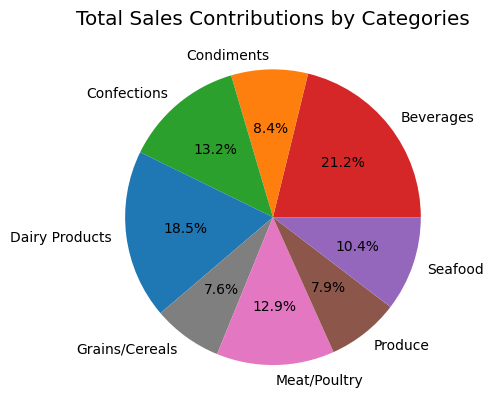

In [70]:
fig, ax = plt.subplots()
ax.pie(category_performance['cat_perc']*100, 
       labels=category_performance['category_name'], 
       autopct='%1.1f%%',
       colors=['tab:red','tab:orange','tab:green','tab:blue',
               'tab:grey','tab:pink','tab:brown','tab:purple'])
plt.title('Total Sales Contributions by Categories')
plt.show()

### Top 3 Products in Every Category
To provide insights into inventory management for boosting sales, the top 3 products in each category will be identified. Sufficient stocks for these products are important to stably drive the sales of the company or even boost sales with suitable marketing plans.

In [71]:
%%sql
SELECT
    OD.product_id, P.product_name, P.category_id, C.category_name,
    ROUND(SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS sales
FROM order_details OD
INNER JOIN products P ON OD.product_id=P.product_id
INNER JOIN categories C ON P.category_id=C.category_id
GROUP BY 1, 2, 3, 4
ORDER BY 3, 1

 * postgresql://postgres@localhost:5432/northwind
77 rows affected.


product_id,product_name,category_id,category_name,sales
1,Chai,1,Beverages,12788
2,Chang,1,Beverages,16356
24,Guaraná Fantástica,1,Beverages,4504
34,Sasquatch Ale,1,Beverages,6350
35,Steeleye Stout,1,Beverages,13644
38,Côte de Blaye,1,Beverages,141397
39,Chartreuse verte,1,Beverages,12295
43,Ipoh Coffee,1,Beverages,23527
67,Laughing Lumberjack Lager,1,Beverages,2397
70,Outback Lager,1,Beverages,10673


In [72]:
%%sql
WITH 
product_sales AS (
    SELECT
        OD.product_id, P.product_name, P.category_id, C.category_name,
        ROUND(SUM(OD.unit_price * OD.quantity * (1-OD.discount))::numeric, 0) AS sales
    FROM order_details OD
    INNER JOIN products P ON OD.product_id=P.product_id
    INNER JOIN categories C ON P.category_id=C.category_id
    GROUP BY 1, 2, 3, 4
    ORDER BY 3, 1
)

SELECT *
FROM (
    SELECT *,
        ROW_NUMBER() OVER(PARTITION BY category_id ORDER BY sales DESC) AS row_th
    FROM product_sales
) AS sub
WHERE row_th <= 3

 * postgresql://postgres@localhost:5432/northwind
24 rows affected.


product_id,product_name,category_id,category_name,sales,row_th
38,Côte de Blaye,1,Beverages,141397,1
43,Ipoh Coffee,1,Beverages,23527,2
2,Chang,1,Beverages,16356,3
63,Vegie-spread,2,Condiments,16701,1
61,Sirop d'érable,2,Condiments,14353,2
65,Louisiana Fiery Hot Pepper Sauce,2,Condiments,13870,3
62,Tarte au sucre,3,Confections,47235,1
20,Sir Rodney's Marmalade,3,Confections,22563,2
26,Gumbär Gummibärchen,3,Confections,19849,3
59,Raclette Courdavault,4,Dairy Products,71156,1


# Conclusion <a class="anchor" id="conclusion"></a>

&emsp;Employees performance was examined. Top employees were found based on all time sales record and withinin 1-year timeframe. Margaret and Janet are the best employees in terms of these criteria. Apart from looking at the sales, hire date could also be put into consideration regarding training and recognition.  
&emsp;The company performance fluctuated throughout the timeframe. There was a significant improvement in the beginning of the year 1998. However, the last month in the record had the worst performance.  
&emsp;Customers with high value orders were also identified. Marketing could be tailor-made to particular countries where there are many high valued customers.  
&emsp;Beverages and dairy products had the biggest contributions to company's overall sales which accounted for 21.2% and 18.5% respectively.